# Data model classifier
This is a project to build a model classifier for the projects subject MC855 at UNICAMP. Let's start by installing all needed dependencies

In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

We will use a dataset with sintetic data from [Vdt.Data](https://www.opendatabay.com/data/financial/59a3ff5b-ae46-4bf1-9f0b-f5959720854e), according the authors: 
> This dataset provides transactional data for detecting card fraud. It includes various features capturing the context, attributes, and outcomes of transactions, enabling users to analyze patterns and identify fraudulent activities. The dataset can be used for fraud detection modeling, data analysis, and testing machine learning algorithms.

#### Dataset Features:
- Transaction_ID: Unique identifier for each transaction.
- User_ID: Unique identifier for each user involved in a transaction.
- Transaction_Amount: The monetary amount of the transaction.
- Transaction_Date: Date of the transaction.
- Transaction_Time: Time of the transaction.
- Transaction_Location: Geographic location where the transaction occurred.
- Merchant_ID: Unique identifier for the merchant involved in the transaction.
- Device_ID: Identifier of the device used for the transaction.
- Card_Type: Type of card used (e.g., UzCard, Humo).
- Transaction_Currency: Currency in which the transaction was processed.
- Transaction_Status: Status of the transaction (e.g., Successful, Failed, Reversed).
- Previous_Transaction_Count: Number of prior transactions made by the user.
- Distance_Between_Transactions_km: Geographical distance between this transaction and the previous one.
- Time_Since_Last_Transaction_min: Time elapsed since the last transaction by the user.
- Authentication_Method: Method used to authenticate the transaction (e.g., 2FA, Biometric).
- Transaction_Velocity: Rate of transactions by the user in a given period.
- Transaction_Category: Type of transaction (e.g., Cash In, Cash Out, Payment).
- isFraud: Binary indicator of whether the transaction was fraudulent (1 for fraud, 0 for non-fraud).


It provides 18 features with 100000 instances, with the target attribute being the "isFraud" field

Let's load the data and visualize a sample of our data:

In [254]:
# Load the dataset
df = pd.read_csv('card_fraud.csv')

## splitting between features and target
# data features only
features = df.drop(columns=['isFraud'])
# target attributes only
target = df['isFraud']

# prints some sample of our data as example
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Date,Transaction_Time,Transaction_Location,Merchant_ID,Device_ID,Card_Type,Transaction_Currency,Transaction_Status,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Authentication_Method,Transaction_Velocity,Transaction_Category,isFraud
0,1001,68389745,69635000,1/1/2024 0:00,0:00:00,Surkhandarya,6710,2060,UzCard,UZS,Successful,35,3481.19,30,2FA,5,Transfer,1
1,1002,42122340,53486000,1/1/2024 0:01,0:01:00,Namangan,6498,2797,UzCard,USD,Successful,35,4341.04,1073,Biometric,9,Cash Out,1
2,1003,87539955,24262000,1/1/2024 0:02,0:02:00,Navoiy,5039,2519,Humo,UZS,Reversed,25,4780.35,132,2FA,7,Cash In,1
3,1004,98657863,56019000,1/1/2024 0:03,0:03:00,Bukhara,6115,2641,Humo,UZS,Failed,44,719.43,41,Biometric,1,Payment,1
4,1005,88084360,87823000,1/1/2024 0:04,0:04:00,Andijan,5072,2923,Humo,UZS,Failed,21,4691.06,458,Password,8,Cash Out,1


Now let's see if we have missing data, if any instance has a missing feature

In [255]:
df.isnull().sum() # sum number of null values for each feature

Transaction_ID                      0
User_ID                             0
Transaction_Amount                  0
Transaction_Date                    0
Transaction_Time                    0
Transaction_Location                0
Merchant_ID                         0
Device_ID                           0
Card_Type                           0
Transaction_Currency                0
Transaction_Status                  0
Previous_Transaction_Count          0
Distance_Between_Transactions_km    0
Time_Since_Last_Transaction_min     0
Authentication_Method               0
Transaction_Velocity                0
Transaction_Category                0
isFraud                             0
dtype: int64

As we can see, we don't have any missing data, so there's no need to make a filter on this criteria

### Splitting the Data (Training vs. Testing)

Before we train our model, we need to split the dataset into two parts:

- Training set (70%) — The data the model learns from
- Testing set (30%) — The data we use to check if the model actually learned anything useful, this will be unseen data for our model. We are only going to use it when we are done with the whole training process

In [256]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 70000 samples
Testing set: 30000 samples


Now, let's do some analysis on our training dataset to check it's distribution

In [257]:
train_data = X_train.join(y_train)
train_data

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Date,Transaction_Time,Transaction_Location,Merchant_ID,Device_ID,Card_Type,Transaction_Currency,Transaction_Status,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Authentication_Method,Transaction_Velocity,Transaction_Category,isFraud
76513,77514,42345577,76494000,2/23/2024 3:13,3:13:00,Samarkand,5625,2171,Humo,UZS,Successful,40,3348.66,1176,Password,5,Payment,0
60406,61407,82616607,48062000,2/11/2024 22:46,22:46:00,Andijan,5250,2446,Humo,USD,Successful,23,4107.49,620,Password,6,Payment,0
27322,28323,25972373,8356000,1/19/2024 23:22,23:22:00,Namangan,6554,2752,UzCard,UZS,Successful,16,1979.32,173,Password,7,Payment,1
53699,54700,80481520,63155000,2/7/2024 6:59,6:59:00,Fergana,5830,2218,Humo,UZS,Successful,22,115.46,864,2FA,2,Transfer,0
65412,66413,31255043,35475000,2/15/2024 10:12,10:12:00,Fergana,5400,2125,UzCard,UZS,Reversed,49,4390.16,413,2FA,4,Cash In,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,7266,23268157,82814000,1/5/2024 8:25,8:25:00,Navoiy,6375,2267,Humo,UZS,Successful,16,2255.41,775,2FA,1,Payment,1
54886,55887,74867679,23064000,2/8/2024 2:46,2:46:00,Navoiy,5447,2875,Humo,USD,Successful,11,3911.97,1060,Password,5,Cash Out,0
76820,77821,12046949,79065000,2/23/2024 8:20,8:20:00,Khorezm,5291,2816,Humo,UZS,Failed,48,3251.28,244,Biometric,7,Cash Out,0
860,1861,53730257,15337000,1/1/2024 14:20,14:20:00,Fergana,6678,2099,UzCard,UZS,Successful,45,128.29,437,2FA,9,Payment,1


### Checking data consistency
we want to check how is the data distribution, by ploting a histogram of ocurrences

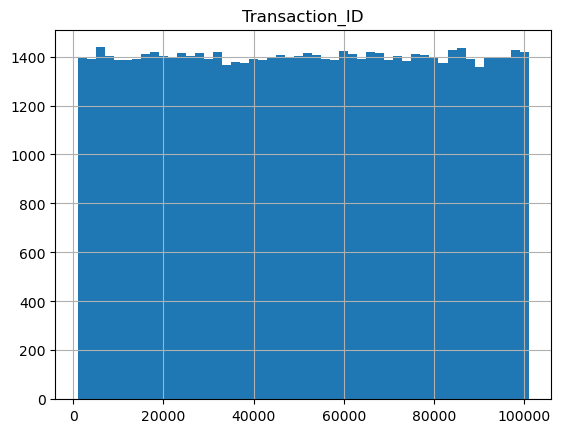

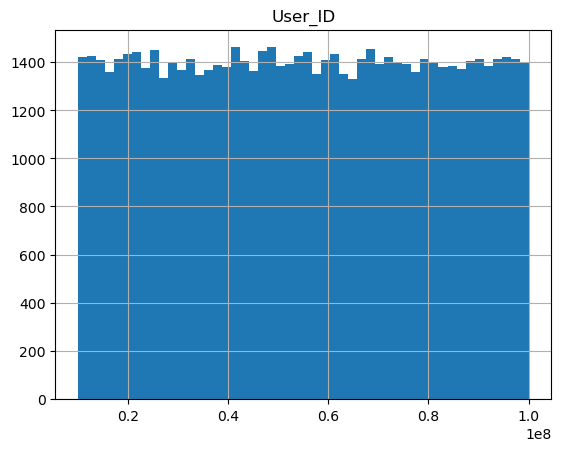

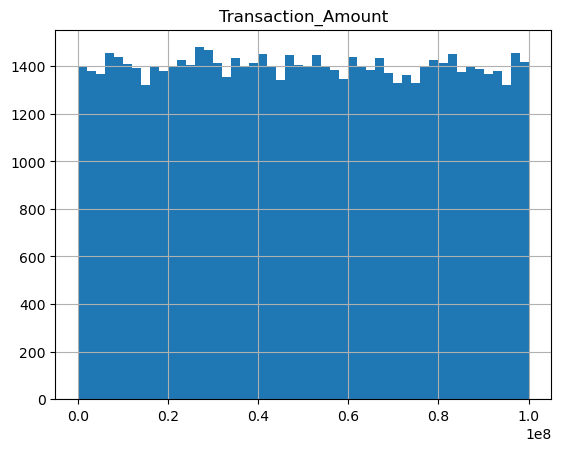

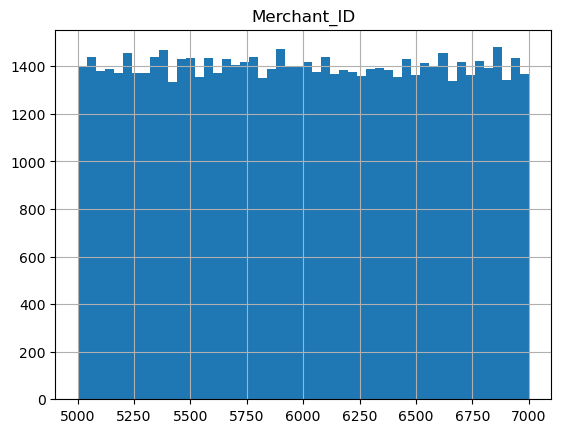

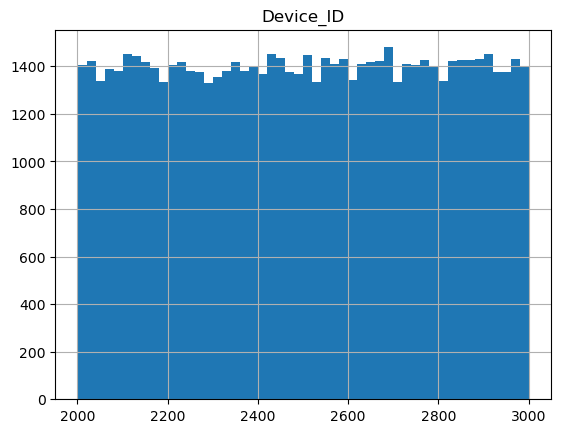

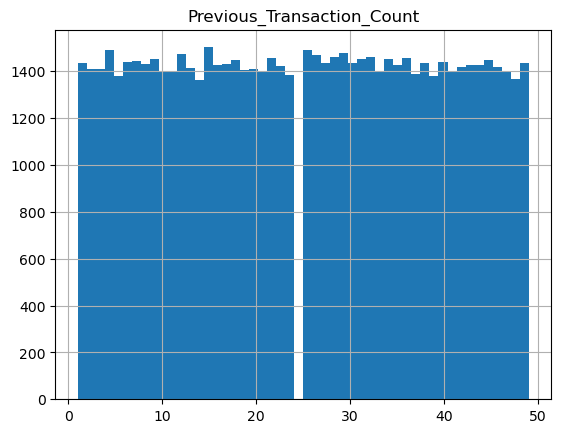

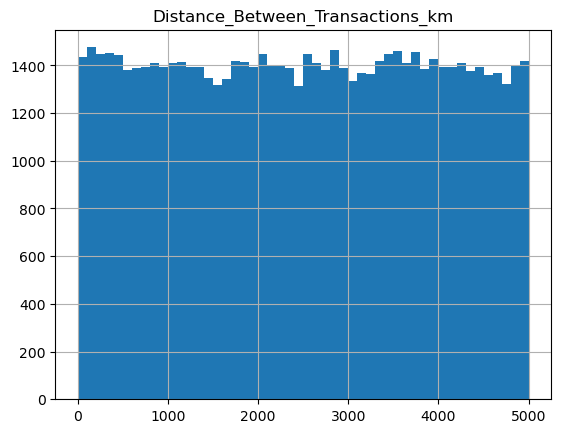

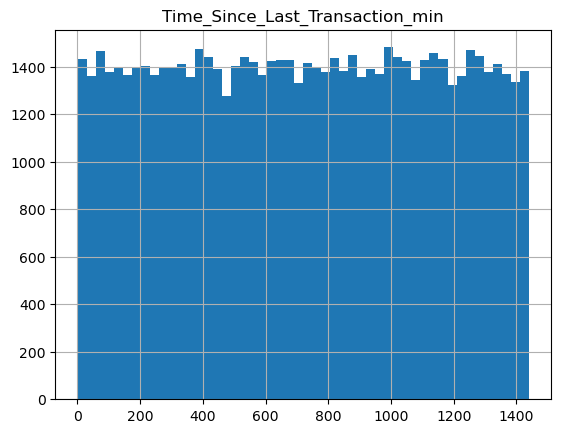

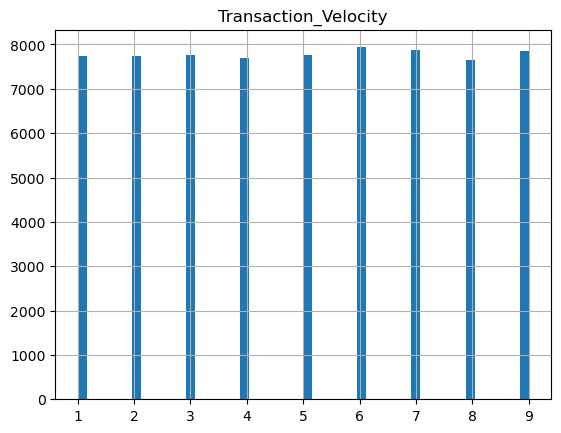

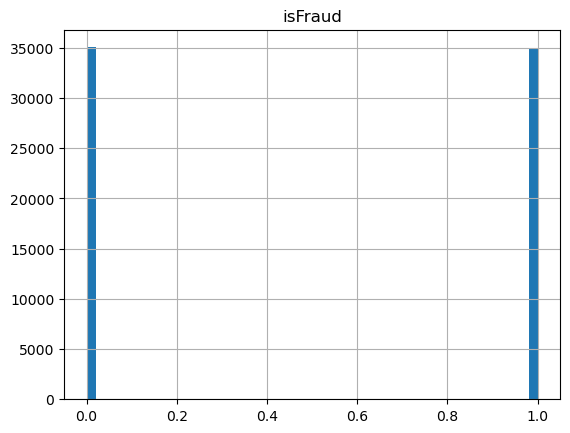

In [258]:
numeric_cols = train_data.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure()
    train_data[col].hist(bins=50)
    plt.title(col)
    plt.show()

The histogram analysis shows that the data is extremely evenly split, which indicates that the data may not reflect real word inputs

Also, let's check how the variables relate with each other by using a heatmap. In this heatmap, the closer they are to one, higher is the relation between two variables

<Axes: >

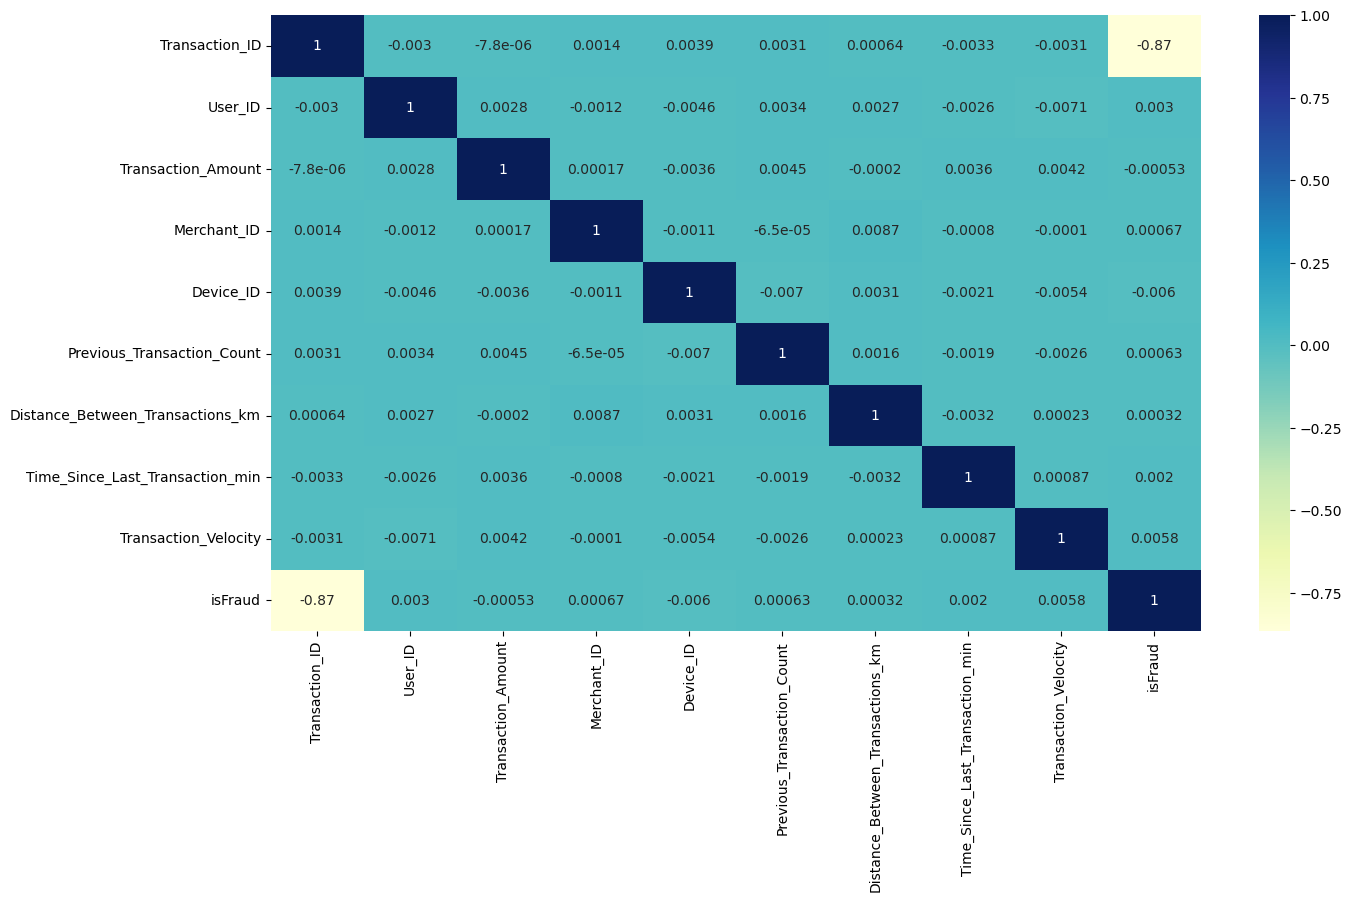

In [259]:
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(numeric_only=True), annot=True, cmap="YlGnBu")

### Data processing

As we can see, Transaction_ID is the only variable that should be discarted in our analysis based on heatmap, as it is an outlier value

The heatmap shows that variables have very close relation values with the target variable, even very specific fields like User_ID, Device_ID and Merchant_ID, we are going to exclude them from our analysis because they are useless for predicting unseen instances (e.g. new Users, devices and merchants)

In [260]:
# Removing attributes
train_data = train_data.drop(['Transaction_ID', 'User_ID', 'Device_ID', 'Merchant_ID'], axis=1)
train_data

,Transaction_Amount,Transaction_Date,Transaction_Time,Transaction_Location,Card_Type,Transaction_Currency,Transaction_Status,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Authentication_Method,Transaction_Velocity,Transaction_Category,isFraud
76513,76494000,2/23/2024 3:13,3:13:00,Samarkand,Humo,UZS,Successful,40,3348.66,1176,Password,5,Payment,0
60406,48062000,2/11/2024 22:46,22:46:00,Andijan,Humo,USD,Successful,23,4107.49,620,Password,6,Payment,0
27322,8356000,1/19/2024 23:22,23:22:00,Namangan,UzCard,UZS,Successful,16,1979.32,173,Password,7,Payment,1
53699,63155000,2/7/2024 6:59,6:59:00,Fergana,Humo,UZS,Successful,22,115.46,864,2FA,2,Transfer,0
65412,35475000,2/15/2024 10:12,10:12:00,Fergana,UzCard,UZS,Reversed,49,4390.16,413,2FA,4,Cash In,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,82814000,1/5/2024 8:25,8:25:00,Navoiy,Humo,UZS,Successful,16,2255.41,775,2FA,1,Payment,1
54886,23064000,2/8/2024 2:46,2:46:00,Navoiy,Humo,USD,Successful,11,3911.97,1060,Password,5,Cash Out,0
76820,79065000,2/23/2024 8:20,8:20:00,Khorezm,Humo,UZS,Failed,48,3251.28,244,Biometric,7,Cash Out,0
860,15337000,1/1/2024 14:20,14:20:00,Fergana,UzCard,UZS,Successful,45,128.29,437,2FA,9,Payment,1


For time attributes, timeline must be ignored

We are going to exclude `Transaction_Time` because it seems to be a continuous value, that will produce noise

On `Transaction_Date` we are going to extract the variables `hour`, `day_of_week` and `month`

In [261]:

if 'Transaction_Date' in train_data.columns and 'Transaction_Time' in train_data.columns:
    train_data['timestamp'] = pd.to_datetime(train_data['Transaction_Date'], errors='coerce')
    valid = train_data['timestamp'].notna()
    if valid.any():
        train_data.loc[valid, 'hour'] = train_data.loc[valid, 'timestamp'].dt.hour
        train_data.loc[valid, 'day_of_week'] = train_data.loc[valid, 'timestamp'].dt.weekday
        train_data.loc[valid, 'month'] = train_data.loc[valid, 'timestamp'].dt.month
    else:
        print('No valid timestamp')
else:
    print('Aviso: no date/time column.')

train_data = train_data.drop(['timestamp', 'Transaction_Time', 'Transaction_Date'], axis=1)
train_data.head()


,Transaction_Amount,Transaction_Location,Card_Type,Transaction_Currency,Transaction_Status,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Authentication_Method,Transaction_Velocity,Transaction_Category,isFraud,hour,day_of_week,month
76513,76494000,Samarkand,Humo,UZS,Successful,40,3348.66,1176,Password,5,Payment,0,3.0,4.0,2.0
60406,48062000,Andijan,Humo,USD,Successful,23,4107.49,620,Password,6,Payment,0,22.0,6.0,2.0
27322,8356000,Namangan,UzCard,UZS,Successful,16,1979.32,173,Password,7,Payment,1,23.0,4.0,1.0
53699,63155000,Fergana,Humo,UZS,Successful,22,115.46,864,2FA,2,Transfer,0,6.0,2.0,2.0
65412,35475000,Fergana,UzCard,UZS,Reversed,49,4390.16,413,2FA,4,Cash In,0,10.0,3.0,2.0


### One hot encoding process
let's transform categorical data into numbers, so we can process them in our model, the one hot encoded features are:
- Transaction_Location
- Card_Type
- Transaction_Currency
- Transaction_Status
- Authentication_Method
- Transaction_Category

In [262]:
train_data = train_data.join(pd.get_dummies(train_data.Transaction_Location)).drop(['Transaction_Location'], axis=1)
train_data = train_data.join(pd.get_dummies(train_data.Card_Type)).drop(['Card_Type'], axis=1)
train_data = train_data.join(pd.get_dummies(train_data.Transaction_Currency)).drop(['Transaction_Currency'], axis=1)
train_data = train_data.join(pd.get_dummies(train_data.Transaction_Status)).drop(['Transaction_Status'], axis=1)
train_data = train_data.join(pd.get_dummies(train_data.Authentication_Method)).drop(['Authentication_Method'], axis=1)
train_data = train_data.join(pd.get_dummies(train_data.Transaction_Category)).drop(['Transaction_Category'], axis=1)

In [263]:
train_data

,Transaction_Amount,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Transaction_Velocity,isFraud,hour,day_of_week,month,Andijan,...,Failed,Reversed,Successful,2FA,Biometric,Password,Cash In,Cash Out,Payment,Transfer
76513,76494000,40,3348.66,1176,5,0,3.0,4.0,2.0,False,...,False,False,True,False,False,True,False,False,True,False
60406,48062000,23,4107.49,620,6,0,22.0,6.0,2.0,True,...,False,False,True,False,False,True,False,False,True,False
27322,8356000,16,1979.32,173,7,1,23.0,4.0,1.0,False,...,False,False,True,False,False,True,False,False,True,False
53699,63155000,22,115.46,864,2,0,6.0,2.0,2.0,False,...,False,False,True,True,False,False,False,False,False,True
65412,35475000,49,4390.16,413,4,0,10.0,3.0,2.0,False,...,False,True,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,82814000,16,2255.41,775,1,1,8.0,4.0,1.0,False,...,False,False,True,True,False,False,False,False,True,False
54886,23064000,11,3911.97,1060,5,0,2.0,3.0,2.0,False,...,False,False,True,False,False,True,False,True,False,False
76820,79065000,48,3251.28,244,7,0,8.0,4.0,2.0,False,...,True,False,False,False,True,False,False,True,False,False
860,15337000,45,128.29,437,9,1,14.0,0.0,1.0,False,...,False,False,True,True,False,False,False,False,True,False


Let's see the distribution after one hot encoding

<Axes: >

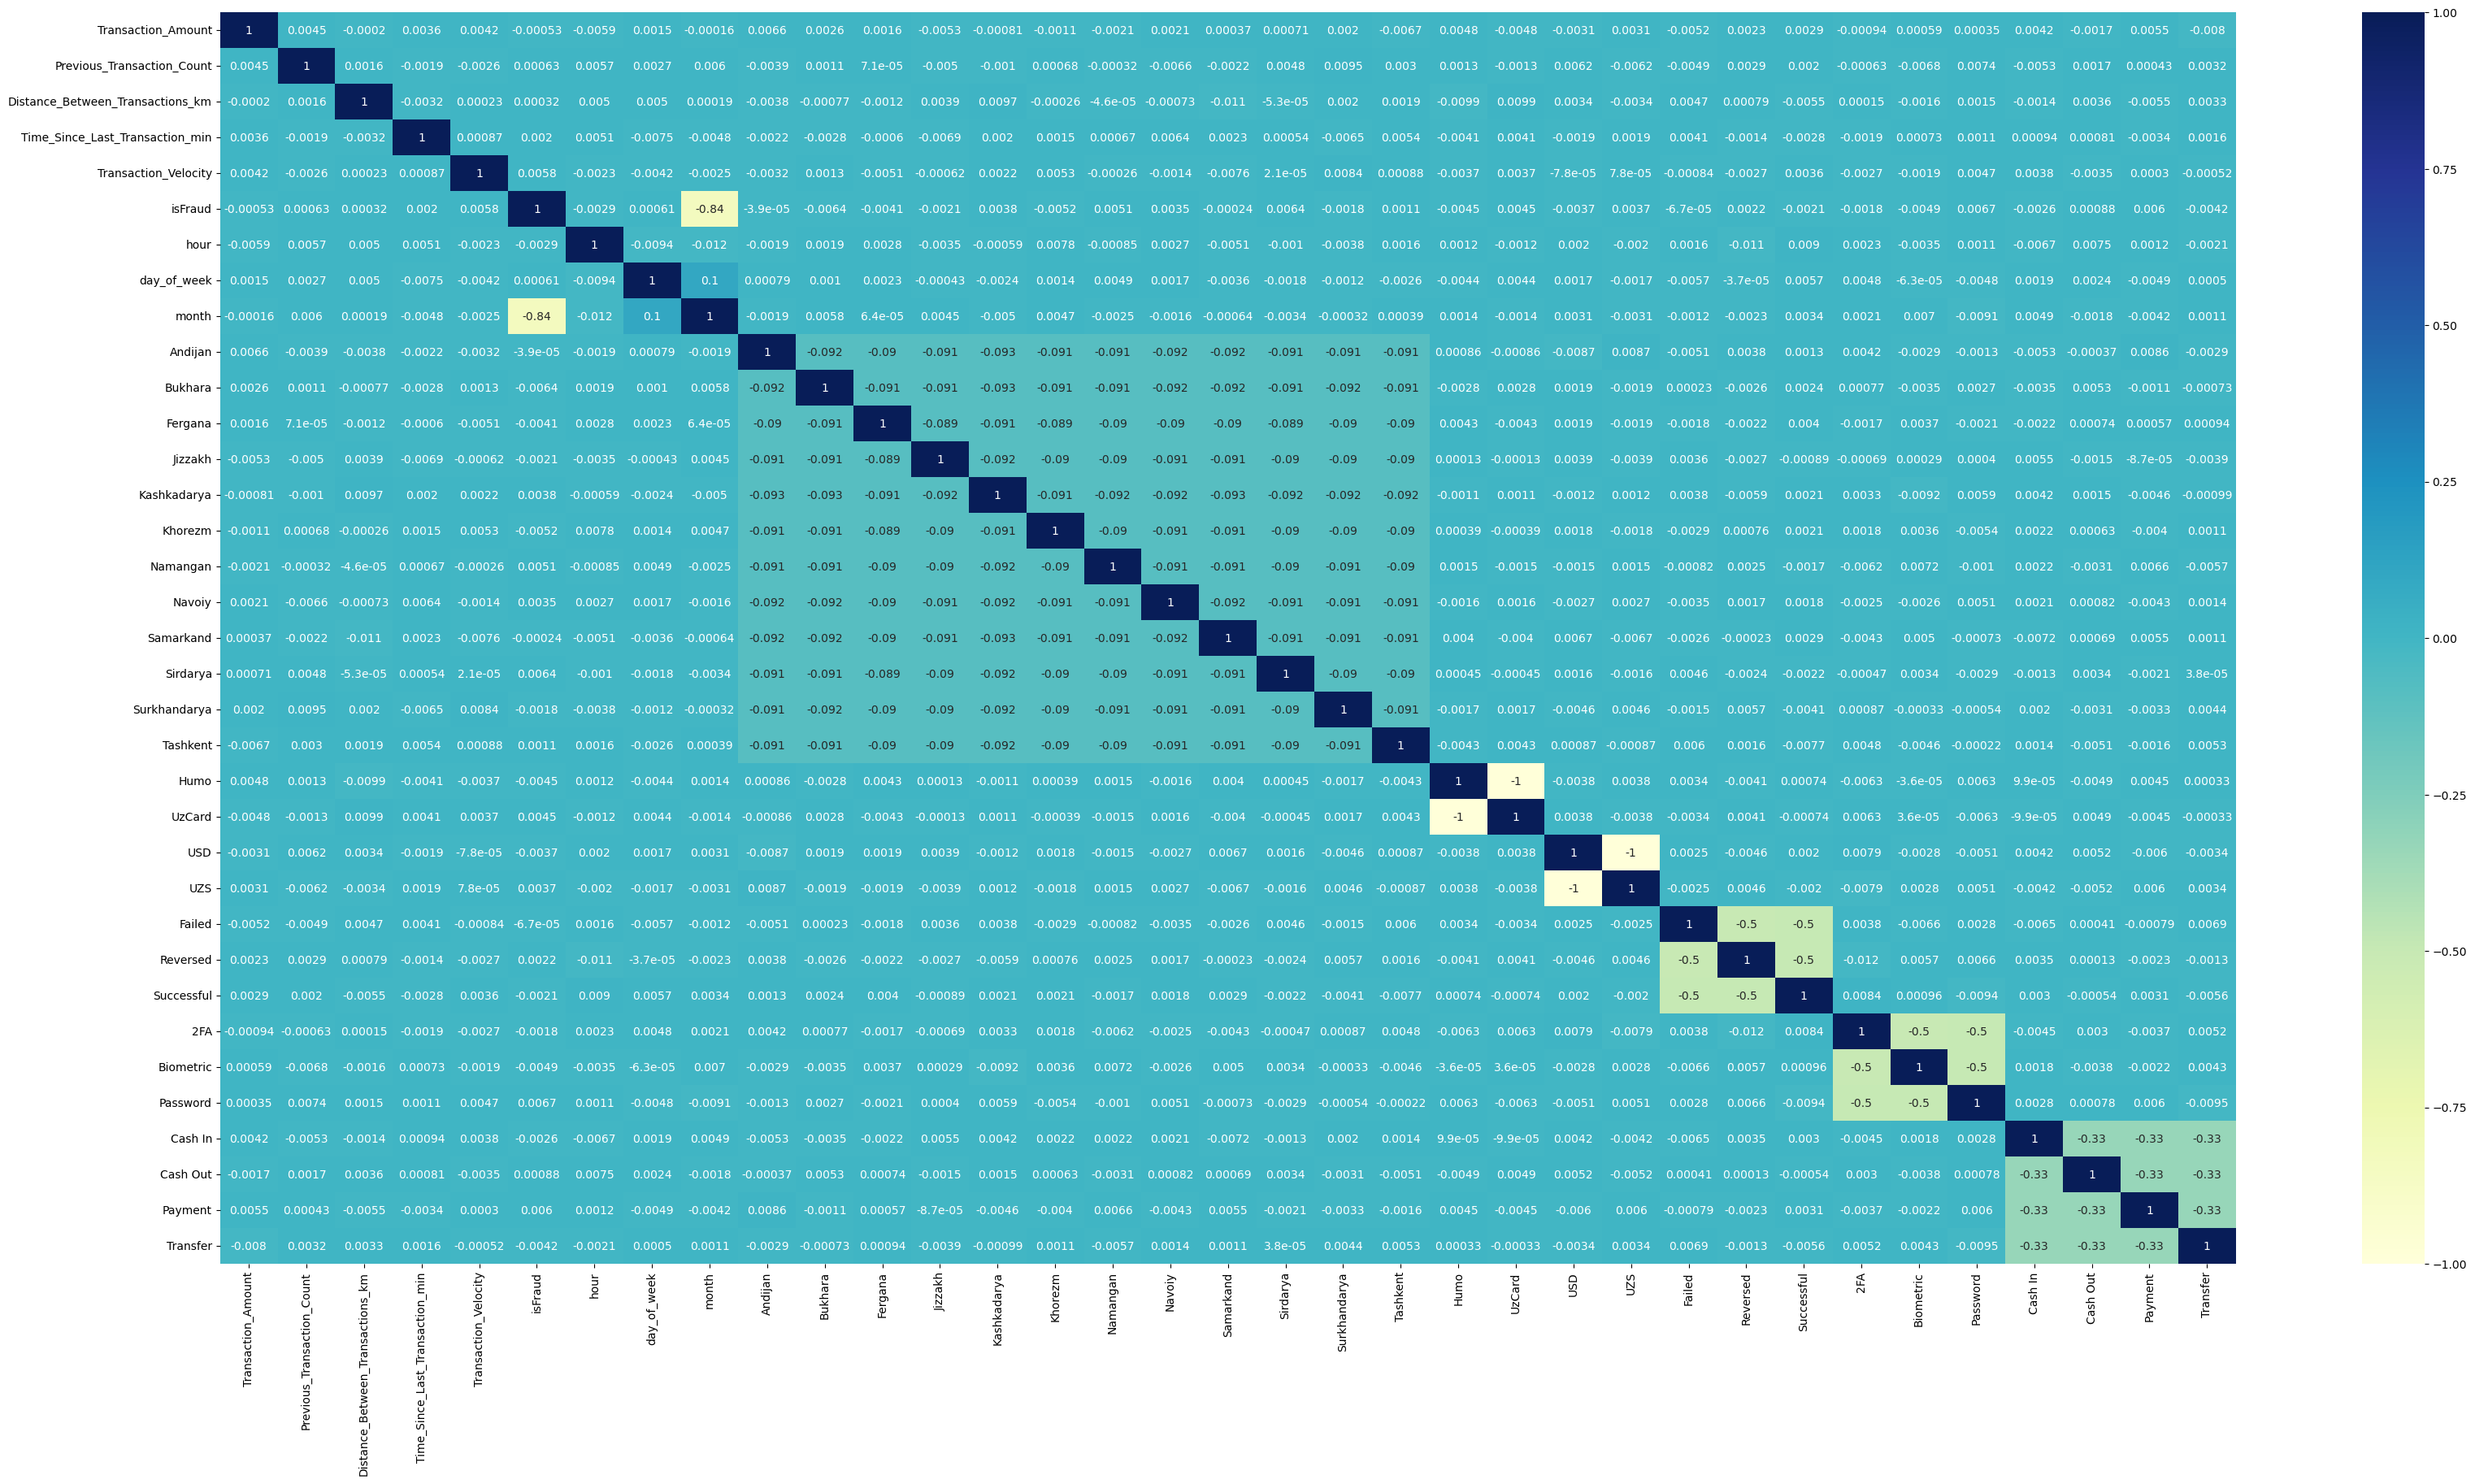

In [264]:
plt.figure(figsize=(40,20))
sns.heatmap(train_data.corr(numeric_only=True), annot=True, cmap="YlGnBu")

Again, all the correlations are very close to each other, except the `month` feature, it seems to be an outlier, so we are going to remove it

In [265]:
train_data = train_data.drop(['month'], axis=1)

In [266]:
train_data

,Transaction_Amount,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Transaction_Velocity,isFraud,hour,day_of_week,Andijan,Bukhara,...,Failed,Reversed,Successful,2FA,Biometric,Password,Cash In,Cash Out,Payment,Transfer
76513,76494000,40,3348.66,1176,5,0,3.0,4.0,False,False,...,False,False,True,False,False,True,False,False,True,False
60406,48062000,23,4107.49,620,6,0,22.0,6.0,True,False,...,False,False,True,False,False,True,False,False,True,False
27322,8356000,16,1979.32,173,7,1,23.0,4.0,False,False,...,False,False,True,False,False,True,False,False,True,False
53699,63155000,22,115.46,864,2,0,6.0,2.0,False,False,...,False,False,True,True,False,False,False,False,False,True
65412,35475000,49,4390.16,413,4,0,10.0,3.0,False,False,...,False,True,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,82814000,16,2255.41,775,1,1,8.0,4.0,False,False,...,False,False,True,True,False,False,False,False,True,False
54886,23064000,11,3911.97,1060,5,0,2.0,3.0,False,False,...,False,False,True,False,False,True,False,True,False,False
76820,79065000,48,3251.28,244,7,0,8.0,4.0,False,False,...,True,False,False,False,True,False,False,True,False,False
860,15337000,45,128.29,437,9,1,14.0,0.0,False,False,...,False,False,True,True,False,False,False,False,True,False


### Feature engineering
Combining and deriving features into new ones could potentially provide us interesting features for our model

Ideas:

🔹 1. Transaction Amount–Based Features

Relative Amount:
Transaction_Amount / (mean(Transaction_Amount) for user) → unusually large transactions.

Amount per Time:
Transaction_Amount / Time_Since_Last_Transaction_min → "spending speed".

Amount per Distance:
Transaction_Amount / Distance_Between_Transactions_km → could signal fraud if someone spends big while moving fast.

🔹 2. Temporal Patterns

Transaction Frequency Spike:
Previous_Transaction_Count / Time_Since_Last_Transaction_min → sudden burst of activity.

Velocity Change:
Transaction_Velocity / mean(Transaction_Velocity for user) → anomalies in transaction pace.

Time-of-Day Flags:
Interactions like (hour in [0–5]) AND (Transaction_Amount > threshold) → frauds often happen at odd hours.

🔹 3. Geospatial + Temporal

Speed Approximation:
Distance_Between_Transactions_km / Time_Since_Last_Transaction_min → suspicious if > commercial travel speed.

Geographic Jumps:
(Distance_Between_Transactions_km > 100) AND (Time_Since_Last_Transaction_min < 30) → "impossible travel".

In [267]:
# Relative transaction amount (vs user mean)
train_data['Rel_Amount_Global'] = train_data['Transaction_Amount'] / train_data['Transaction_Amount'].mean()

# # Amount per time since last transaction
train_data['Amount_per_Time'] = train_data['Transaction_Amount'] / (
    train_data['Time_Since_Last_Transaction_min'].replace(0, np.nan)
)

# # Amount per distance traveled
train_data['Amount_per_Distance'] = train_data['Transaction_Amount'] / (
    train_data['Distance_Between_Transactions_km'].replace(0, np.nan)
)

# # -------------------------
# # 2. Temporal Patterns
# # -------------------------

# # Frequency spike = count / minutes since last
train_data['Freq_Spike'] = train_data['Previous_Transaction_Count'] / (
    train_data['Time_Since_Last_Transaction_min'].replace(0, np.nan)
)

# # Velocity change (vs overall mean)
train_data['Velocity_Change'] = train_data['Transaction_Velocity'] / (
    train_data['Transaction_Velocity'].mean()
)

# # Odd hour flag
train_data['Odd_Hour'] = train_data['hour'].apply(lambda x: 1 if x < 6 else 0)

# # -------------------------
# # 3. Geospatial + Temporal
# # -------------------------

# # Speed approximation (km/min)
train_data['Approx_Speed'] = train_data['Distance_Between_Transactions_km'] / (
    train_data['Time_Since_Last_Transaction_min'].replace(0, np.nan)
)

# # Impossible travel flag
train_data['Impossible_Travel'] = (
    (train_data['Distance_Between_Transactions_km'] > 100) &
    (train_data['Time_Since_Last_Transaction_min'] < 30)
).astype(int)

In [268]:
train_data

,Transaction_Amount,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Transaction_Velocity,isFraud,hour,day_of_week,Andijan,Bukhara,...,Payment,Transfer,Rel_Amount_Global,Amount_per_Time,Amount_per_Distance,Freq_Spike,Velocity_Change,Odd_Hour,Approx_Speed,Impossible_Travel
76513,76494000,40,3348.66,1176,5,0,3.0,4.0,False,False,...,True,False,1.533284,65045.918367,22843.167118,0.034014,0.998138,1,2.847500,0
60406,48062000,23,4107.49,620,6,0,22.0,6.0,True,False,...,True,False,0.963379,77519.354839,11701.063180,0.037097,1.197765,0,6.624984,0
27322,8356000,16,1979.32,173,7,1,23.0,4.0,False,False,...,True,False,0.167492,48300.578035,4221.651880,0.092486,1.397393,0,11.441156,0
53699,63155000,22,115.46,864,2,0,6.0,2.0,False,False,...,False,True,1.265910,73096.064815,546985.969167,0.025463,0.399255,0,0.133634,0
65412,35475000,49,4390.16,413,4,0,10.0,3.0,False,False,...,False,False,0.711079,85895.883777,8080.571095,0.118644,0.798510,0,10.629927,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,82814000,16,2255.41,775,1,1,8.0,4.0,False,False,...,True,False,1.659965,106856.774194,36717.935985,0.020645,0.199628,0,2.910206,0
54886,23064000,11,3911.97,1060,5,0,2.0,3.0,False,False,...,False,False,0.462306,21758.490566,5895.750734,0.010377,0.998138,1,3.690538,0
76820,79065000,48,3251.28,244,7,0,8.0,4.0,False,False,...,False,False,1.584819,324036.885246,24318.114712,0.196721,1.397393,0,13.324918,0
860,15337000,45,128.29,437,9,1,14.0,0.0,False,False,...,True,False,0.307423,35096.109840,119549.458259,0.102975,1.796648,0,0.293570,0


Visualizing how this new features behave, we can keep them on our model, since they seem to have relation with the target variable

<Axes: >

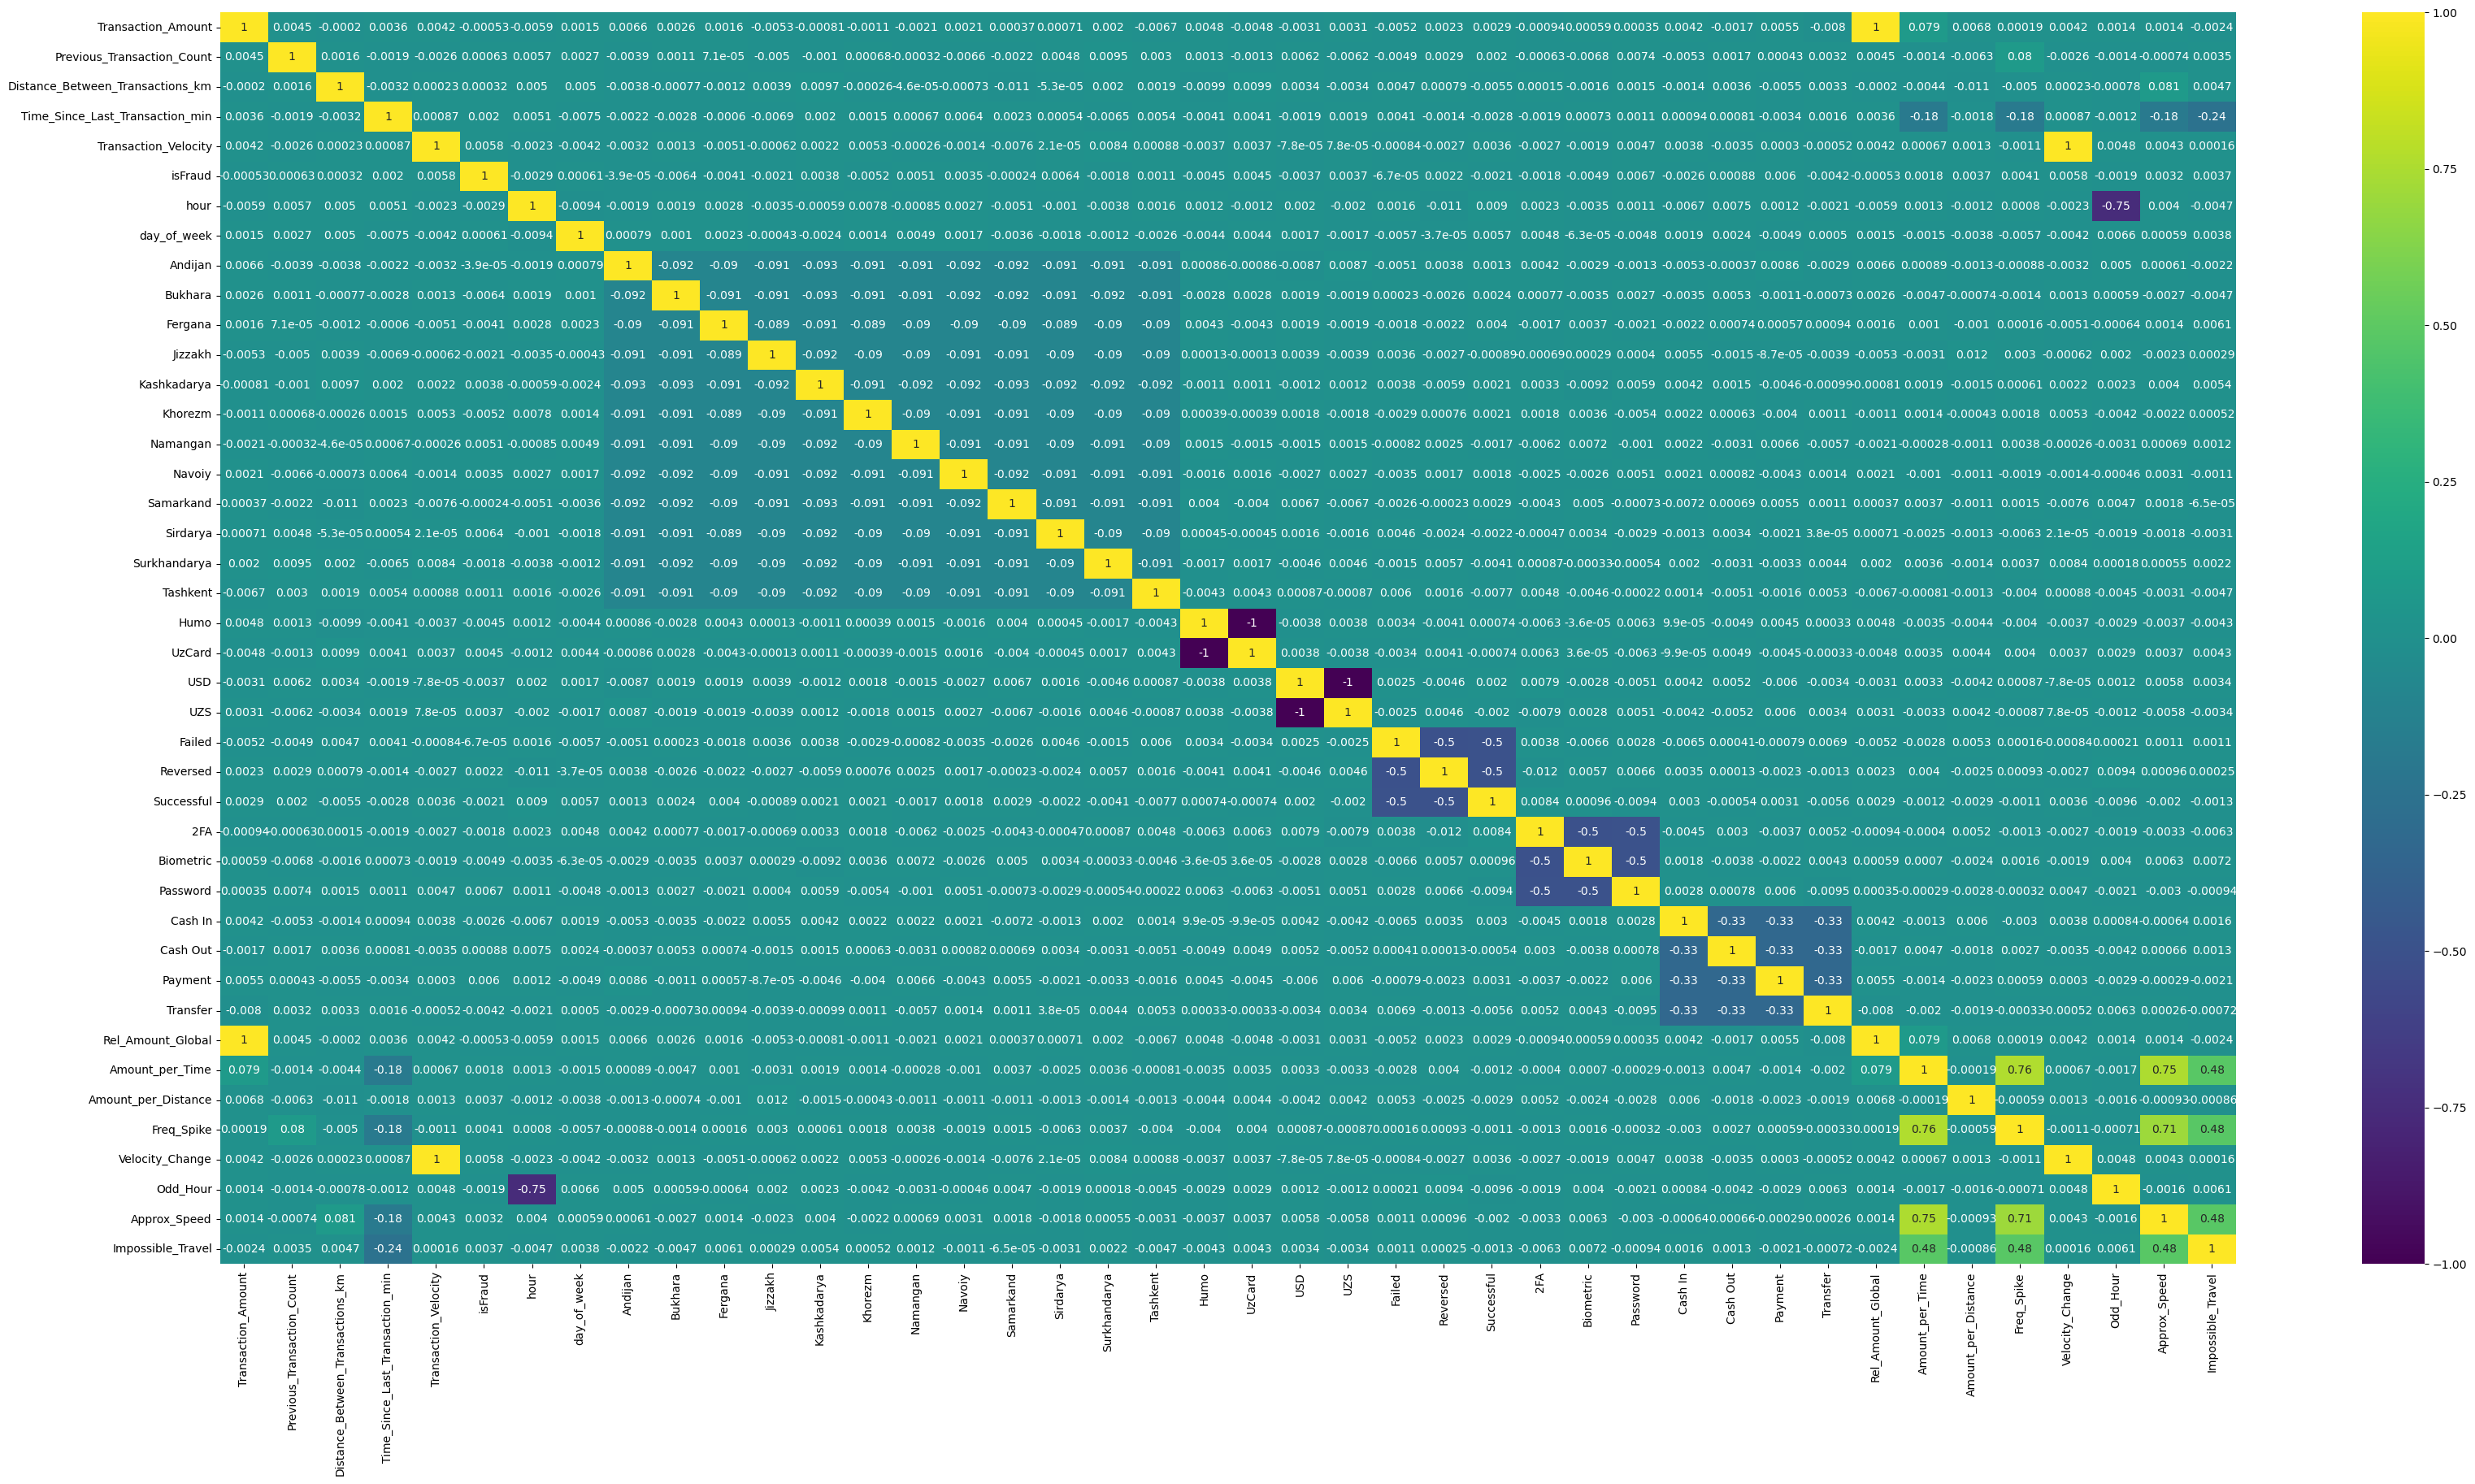

In [269]:
plt.figure(figsize=(40,20))
sns.heatmap(train_data.corr(numeric_only=True), annot=True, cmap="viridis")

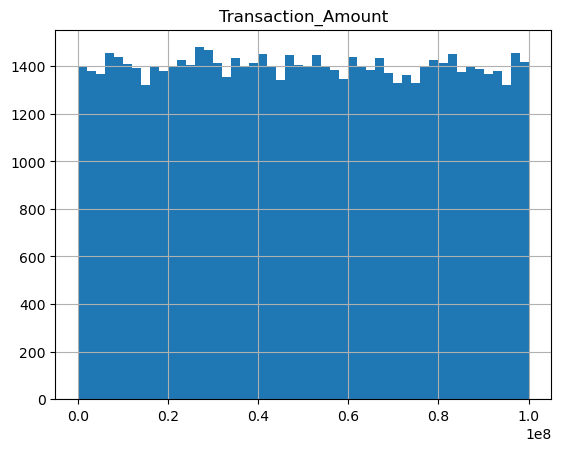

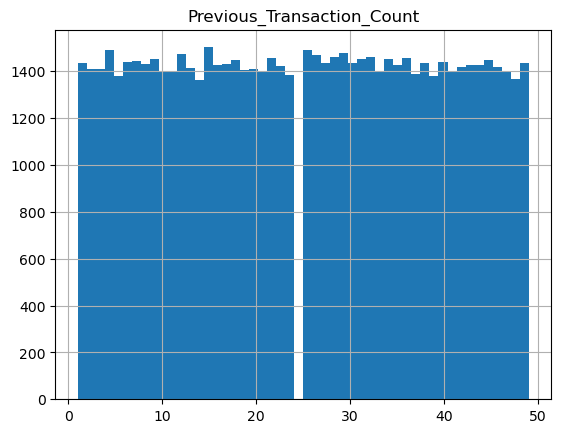

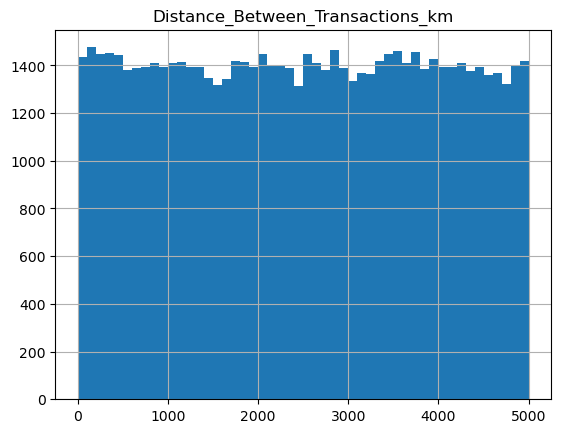

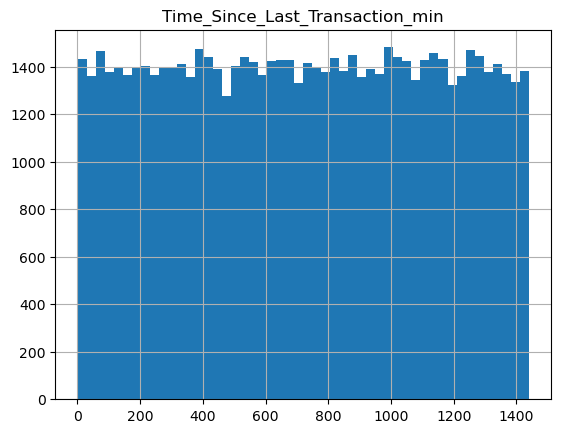

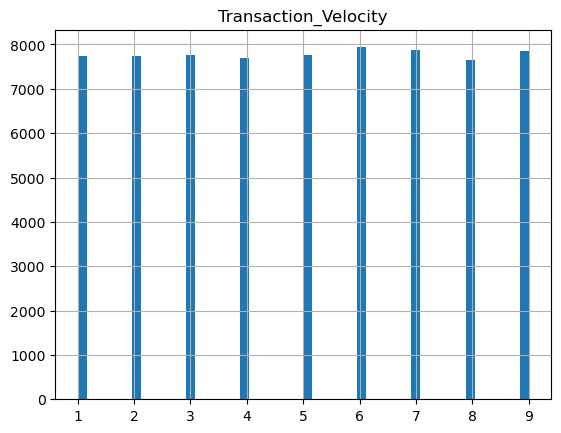

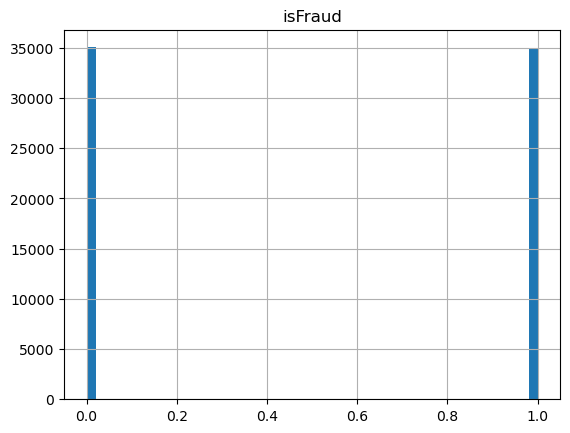

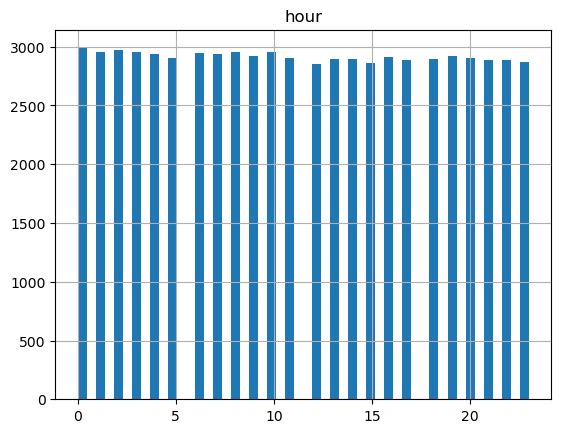

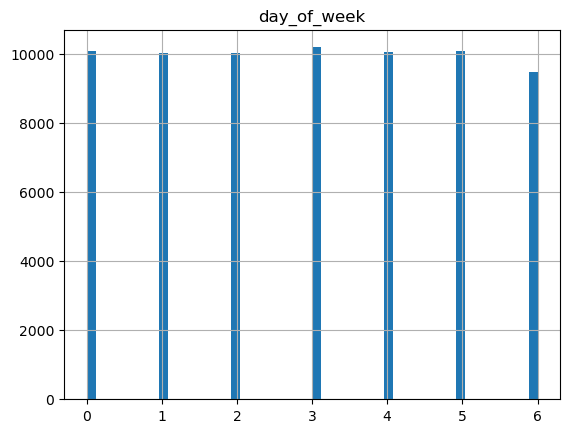

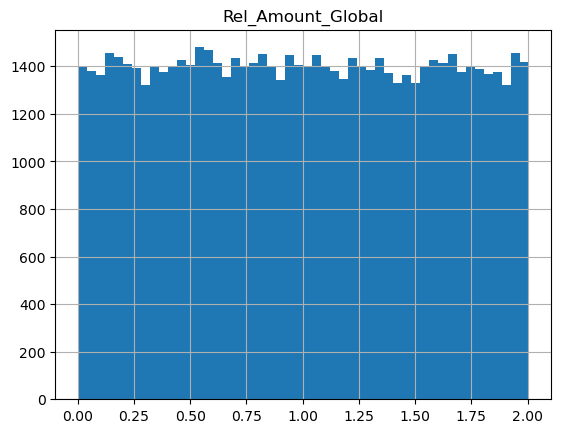

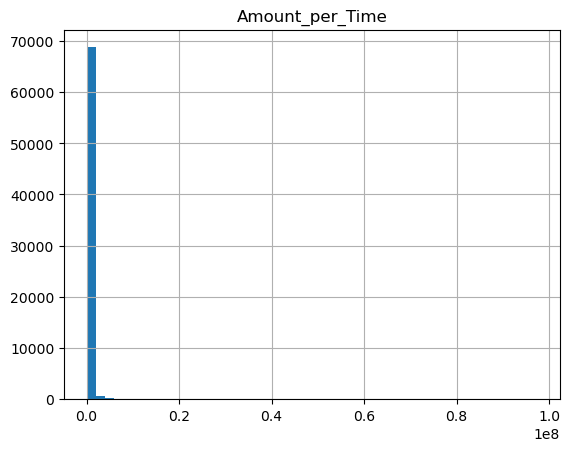

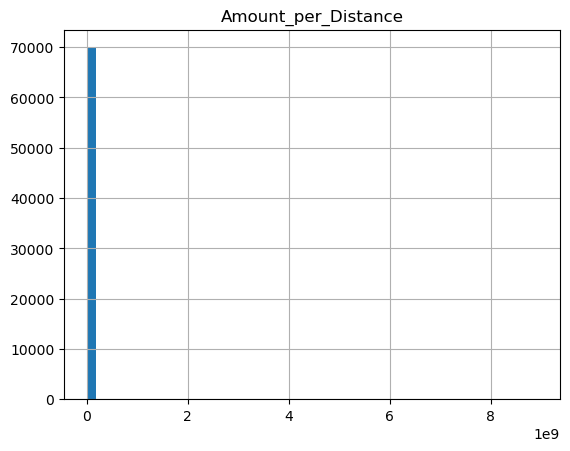

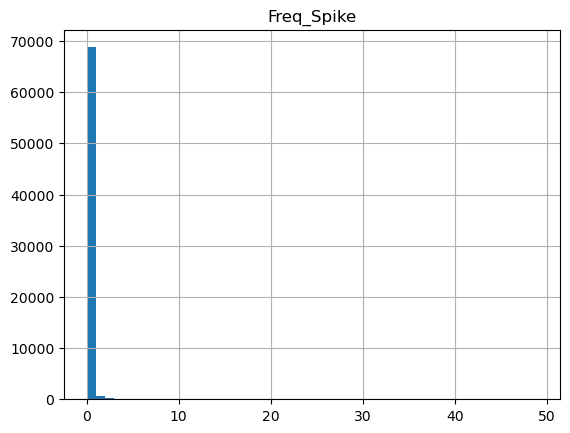

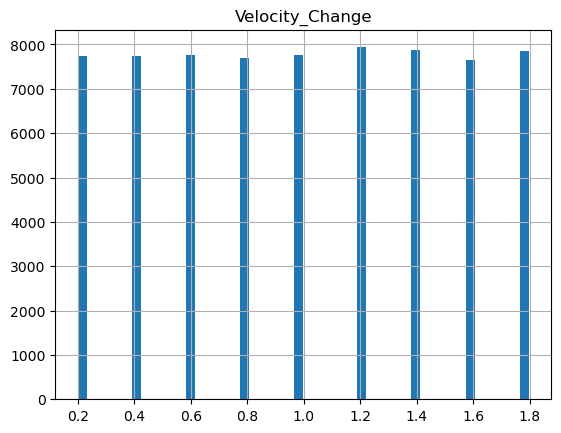

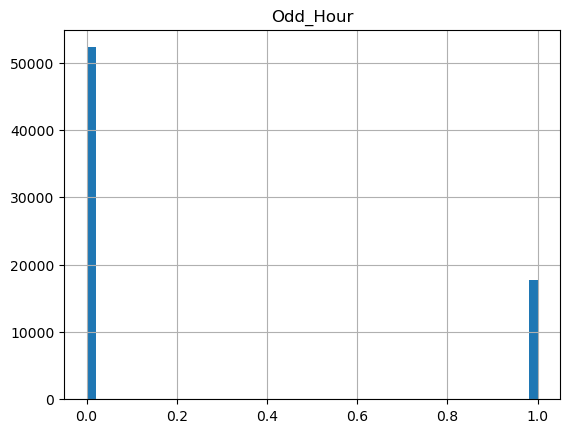

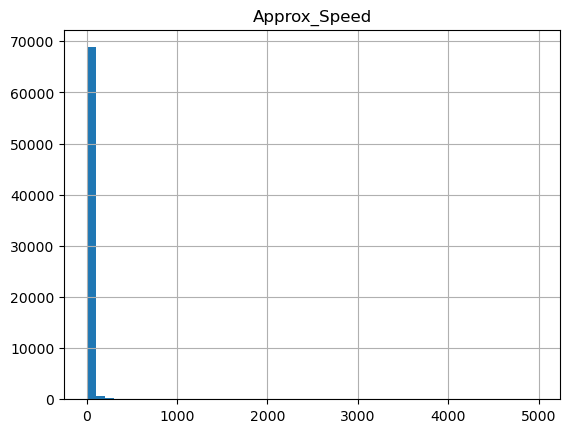

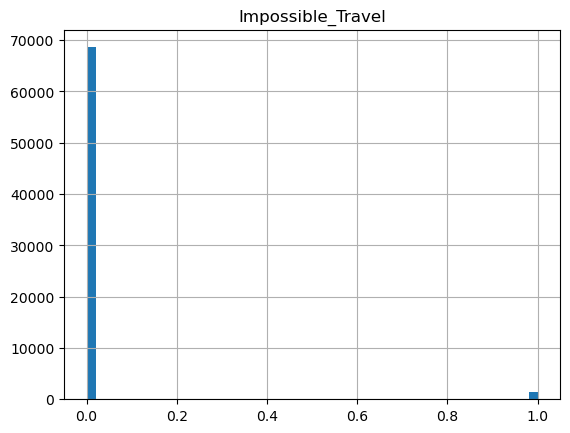

In [270]:
numeric_cols = train_data.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure()
    train_data[col].hist(bins=50)
    plt.title(col)
    plt.show()

### Sanitizing the test data

Before checking how our model perform, let's first format the test data as an input for the model. All transformations operations done in the train_dataset must also be applied to the test

In [271]:
X_test

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Date,Transaction_Time,Transaction_Location,Merchant_ID,Device_ID,Card_Type,Transaction_Currency,Transaction_Status,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Authentication_Method,Transaction_Velocity,Transaction_Category
75721,76722,18312161,3712000,2/22/2024 14:01,14:01:00,Namangan,6962,2377,UzCard,USD,Failed,47,3763.23,858,Biometric,9,Transfer
80184,81185,75374643,88147000,2/25/2024 16:24,16:24:00,Bukhara,6547,2965,Humo,USD,Failed,45,1964.57,1253,2FA,8,Cash In
19864,20865,41709653,45548000,1/14/2024 19:04,19:04:00,Sirdarya,5144,2420,UzCard,USD,Reversed,34,1700.36,1212,2FA,9,Cash Out
76699,77700,18122643,91114000,2/23/2024 6:19,6:19:00,Navoiy,5668,2161,UzCard,USD,Successful,39,4970.08,1252,Password,3,Transfer
92991,93992,98608658,91841000,3/5/2024 13:51,13:51:00,Surkhandarya,6364,2077,Humo,UZS,Failed,14,2405.75,1038,Biometric,3,Cash In
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42648,43649,49129599,9355000,1/30/2024 14:48,14:48:00,Fergana,6851,2852,UzCard,USD,Reversed,32,4819.70,549,Biometric,1,Cash In
86306,87307,59658640,55627000,2/29/2024 22:26,22:26:00,Bukhara,5962,2679,Humo,UZS,Successful,6,1739.98,409,Password,6,Payment
45466,46467,97034163,37221000,2/1/2024 13:46,13:46:00,Sirdarya,5748,2895,UzCard,USD,Failed,16,2890.77,1282,Password,8,Payment
63724,64725,70664648,79722000,2/14/2024 6:04,6:04:00,Samarkand,6861,2979,Humo,UZS,Failed,14,1985.56,710,Biometric,3,Cash In


In [272]:
X_test = X_test.drop(['Transaction_ID', 'User_ID', 'Device_ID', 'Merchant_ID'], axis=1)

if 'Transaction_Date' in X_test.columns and 'Transaction_Time' in X_test.columns:
    X_test['timestamp'] = pd.to_datetime(X_test['Transaction_Date'], errors='coerce')
    valid = X_test['timestamp'].notna()
    if valid.any():
        X_test.loc[valid, 'hour'] = X_test.loc[valid, 'timestamp'].dt.hour
        X_test.loc[valid, 'day_of_week'] = X_test.loc[valid, 'timestamp'].dt.weekday
        X_test.loc[valid, 'month'] = X_test.loc[valid, 'timestamp'].dt.month
    else:
        print('No valid timestamp')
else:
    print('Aviso: no date/time column.')

X_test = X_test.drop(['timestamp', 'Transaction_Time', 'Transaction_Date'], axis=1)
X_test.head()
X_test = X_test.join(pd.get_dummies(X_test.Transaction_Location)).drop(['Transaction_Location'], axis=1)
X_test = X_test.join(pd.get_dummies(X_test.Card_Type)).drop(['Card_Type'], axis=1)
X_test = X_test.join(pd.get_dummies(X_test.Transaction_Currency)).drop(['Transaction_Currency'], axis=1)
X_test = X_test.join(pd.get_dummies(X_test.Transaction_Status)).drop(['Transaction_Status'], axis=1)
X_test = X_test.join(pd.get_dummies(X_test.Authentication_Method)).drop(['Authentication_Method'], axis=1)
X_test = X_test.join(pd.get_dummies(X_test.Transaction_Category)).drop(['Transaction_Category'], axis=1)
X_test = X_test.drop(['month'], axis=1)
X_test['Rel_Amount_Global'] = X_test['Transaction_Amount'] / X_test['Transaction_Amount'].mean()
X_test['Amount_per_Time'] = X_test['Transaction_Amount'] / (
    X_test['Time_Since_Last_Transaction_min'].replace(0, np.nan)
)
X_test['Amount_per_Distance'] = X_test['Transaction_Amount'] / (
    X_test['Distance_Between_Transactions_km'].replace(0, np.nan)
)
X_test['Freq_Spike'] = X_test['Previous_Transaction_Count'] / (
    X_test['Time_Since_Last_Transaction_min'].replace(0, np.nan)
)
X_test['Velocity_Change'] = X_test['Transaction_Velocity'] / (
    X_test['Transaction_Velocity'].mean()
)
X_test['Odd_Hour'] = X_test['hour'].apply(lambda x: 1 if x < 6 else 0)
X_test['Approx_Speed'] = X_test['Distance_Between_Transactions_km'] / (
    X_test['Time_Since_Last_Transaction_min'].replace(0, np.nan)
)
X_test['Impossible_Travel'] = (
    (X_test['Distance_Between_Transactions_km'] > 100) &
    (X_test['Time_Since_Last_Transaction_min'] < 30)
).astype(int)
X_test

,Transaction_Amount,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Transaction_Velocity,hour,day_of_week,Andijan,Bukhara,Fergana,...,Payment,Transfer,Rel_Amount_Global,Amount_per_Time,Amount_per_Distance,Freq_Spike,Velocity_Change,Odd_Hour,Approx_Speed,Impossible_Travel
75721,3712000,47,3763.23,858,9,14.0,3.0,False,False,False,...,False,True,0.074107,4.326340e+03,986.386694,0.054779,1.799064,0,4.386049,0
80184,88147000,45,1964.57,1253,8,16.0,6.0,False,True,False,...,False,False,1.759791,7.034876e+04,44868.342691,0.035914,1.599168,0,1.567893,0
19864,45548000,34,1700.36,1212,9,19.0,6.0,False,False,False,...,False,False,0.909333,3.758086e+04,26787.268578,0.028053,1.799064,0,1.402937,0
76699,91114000,39,4970.08,1252,3,6.0,4.0,False,False,False,...,False,True,1.819025,7.277476e+04,18332.501690,0.031150,0.599688,0,3.969712,0
92991,91841000,14,2405.75,1038,3,13.0,1.0,False,False,False,...,False,False,1.833539,8.847881e+04,38175.620908,0.013487,0.599688,0,2.317678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42648,9355000,32,4819.70,549,1,14.0,1.0,False,False,True,...,False,False,0.186766,1.704007e+04,1940.992178,0.058288,0.199896,0,8.779053,0
86306,55627000,6,1739.98,409,6,22.0,3.0,False,True,False,...,True,False,1.110553,1.360073e+05,31969.907700,0.014670,1.199376,0,4.254230,0
45466,37221000,16,2890.77,1282,8,13.0,3.0,False,False,False,...,True,False,0.743090,2.903354e+04,12875.808176,0.012480,1.599168,0,2.254891,0
63724,79722000,14,1985.56,710,3,6.0,2.0,False,False,False,...,False,False,1.591592,1.122845e+05,40150.889422,0.019718,0.599688,0,2.796563,0


### Model exploration
As we have several categorical data, we choose Random Forest

#### Random Forest

In [273]:
# Features (all columns except target)
X_train = train_data.drop(columns=['isFraud'])
# Target
y_train = train_data['isFraud']

In [280]:

model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Show a full classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.49
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.53      0.51     14945
           1       0.50      0.46      0.48     15055

    accuracy                           0.49     30000
   macro avg       0.49      0.49      0.49     30000
weighted avg       0.49      0.49      0.49     30000



#### Hyperparameter Tuning (Making the Model Smarter)

Most machine learning models have hyperparameters — think of these as adjustable settings that can affect how the model learns. We can use GridSearchCV to automatically find the best ones, so we can try to improve our model

In [ ]:

# Define the model
model = RandomForestClassifier()

# Define hyperparameters to test
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

best_forest = grid_search.best_estimator_
best_forest.score(X_test, y_test)

### Considerations and next steps

What are our current incomings
What we need to do next based on the current analysis